## Sediment Load Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# import SSC continuous record
SSC_spring = pd.read_csv('../../data/SSC/turb_SS_spring.csv', parse_dates=True , index_col='Date_Time') # in mg/L
SSC_summer = pd.read_csv('../../data/SSC/turb_SS_summer.csv', parse_dates=True , index_col='Date_Time') # in mg/L
# drop the Sample column, we will merge later
SSC_spring.drop(columns=['Sample SSC'], inplace=True)
SSC_summer.drop(columns=['Sample SSC'], inplace=True)
# import SSC sample record
SSC_spring_sample = pd.read_csv('../../data/SSC/samples_spring_SSC.csv', parse_dates=True, index_col='Date_Time') # in mg/L
SSC_summer_sample = pd.read_csv('../../data/SSC/samples_summer_SSC.csv', parse_dates=True, index_col='Date_Time') # in mg/L
# import discharge continuous record
discharge = pd.read_csv('../../data/discharge/discharge_2023.csv', parse_dates=True, index_col='Date_Time')

In [2]:
# functions 
def evaluate_prediction(data, measured, predicted):
    """
    evaluate prediction performance using r2 and rmse
    """
    # remove nan values using dropna
    clean_data = data[[measured, predicted]].dropna()
    if clean_data.empty:
        raise ValueError('no valid data available for regression')
    
    true = clean_data[measured].values
    pred = clean_data[predicted].values

    # calculate metrics
    r2 = r2_score(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    
    return r2, rmse

Merge discharge to SSC 

In [3]:
# resample and interpolate to 1 min intervals
SSC_spring = SSC_spring.resample('1min').mean().interpolate(method='linear')
SSC_summer = SSC_summer.resample('1min').mean().interpolate(method='linear')
discharge = discharge.resample('1min').mean().interpolate(method='linear')

# merge discharge to SSC by date (index)
SSC_spring = SSC_spring.merge(discharge, left_index=True, right_index=True, how='left') 
SSC_summer = SSC_summer.merge(discharge, left_index=True, right_index=True, how='left')
# merge discharge to SSC sample by date (index)
SSC_spring_sample = SSC_spring_sample.merge(discharge, left_index=True, right_index=True, how='left')
SSC_summer_sample = SSC_summer_sample.merge(discharge, left_index=True, right_index=True, how='left')

Calculate Qs (Sediment Load in grams/seconds)

In [4]:
# for continuos records, calculate Qs (Sediment Load in g/s)
SSC_spring['Qs'] = SSC_spring['SSC (mg/L)'] * SSC_spring['Q'] # mg/L * m^3/s = g/s, assuming 1m3 = 1000L and 1g = 1000mg
SSC_summer['Qs'] = SSC_summer['SSC (mg/L)'] * SSC_summer['Q']  
# for sample records, calculate Qs (Sediment Load in g/s)
SSC_spring_sample['Qs'] = SSC_spring_sample['SSC'] * SSC_spring_sample['Q'] 
SSC_summer_sample['Qs'] = SSC_summer_sample['SSC'] * SSC_summer_sample['Q'] 

### Plots

Calculated SS load (turbidity record) vs observed SS load (samples)

In [5]:
# merge continuous to sample record
SSC_spring_sample = SSC_spring_sample.merge(SSC_spring['Qs'], left_index=True, right_index=True, how='left', suffixes=('', '_turb'))
SSC_summer_sample = SSC_summer_sample.merge(SSC_summer['Qs'], left_index=True, right_index=True, how='left', suffixes=('', '_turb'))

# sort the data by index (date)
SSC_spring_sample = SSC_spring_sample.sort_index()
SSC_summer_sample = SSC_summer_sample.sort_index()

# compute metrics for each season
r2_spring, rmse_spring = evaluate_prediction(SSC_spring_sample, 'Qs', 'Qs_turb')
r2_summer, rmse_summer = evaluate_prediction(SSC_summer_sample, 'Qs', 'Qs_turb')

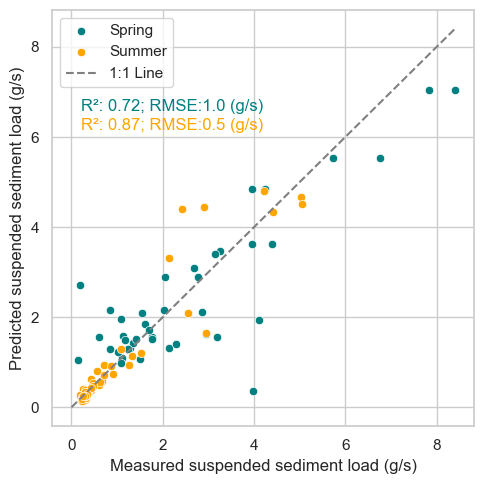

In [6]:
# scatter plot of continuous vs sample records
sns.set(style="whitegrid")
plt.figure(figsize=(5, 5))
sns.scatterplot(data=SSC_spring_sample, x='Qs', y='Qs_turb', label='Spring', color='teal')
sns.scatterplot(data=SSC_summer_sample, x='Qs', y='Qs_turb', label='Summer', color='orange')
# plot 1:1 line
plt.plot([0, SSC_spring_sample['Qs'].max()], [0, SSC_spring_sample['Qs'].max()], color='gray', linestyle='--', label='1:1 Line')
# add r2 and RMSE to the plot
plt.text(0.2, 6.5, f'R²: {r2_spring:.2f}; RMSE:{rmse_spring:.1f} (g/s)', fontsize=12, verticalalignment='bottom', color='teal')
plt.text(0.2, 6.1, f'R²: {r2_summer:.2f}; RMSE:{rmse_summer:.1f} (g/s)', fontsize=12, verticalalignment='bottom', color='orange')
plt.xlabel('Measured suspended sediment load (g/s)')
plt.ylabel('Predicted suspended sediment load (g/s)')
plt.legend()
plt.tight_layout()
plt.show()


Time Series

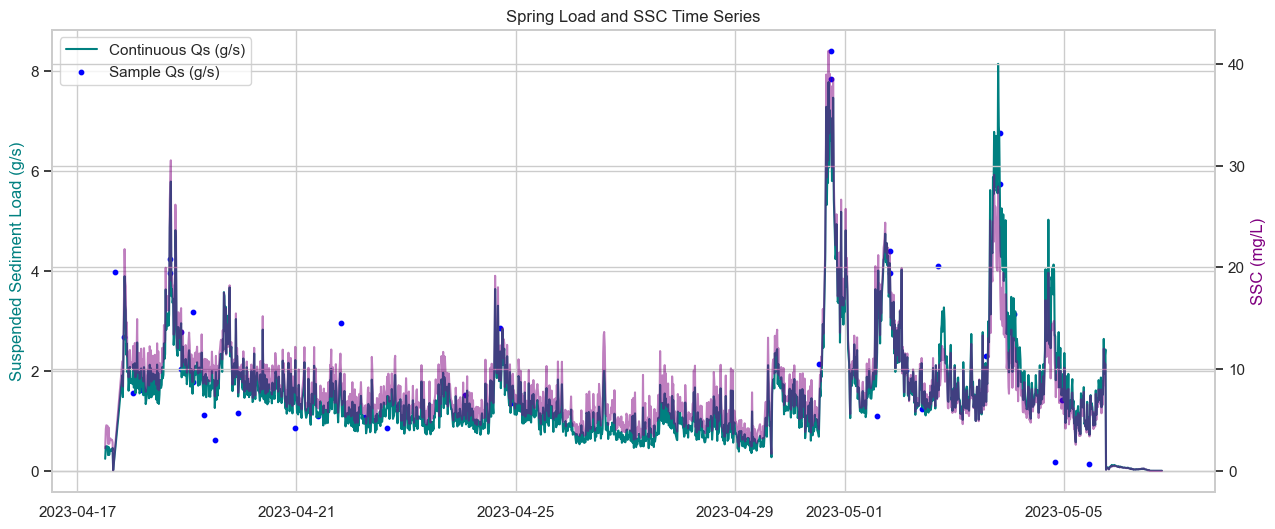

In [7]:
# plot time series of spring continuous record
plt.figure(figsize=(15, 6))
plt.plot(SSC_spring.index, SSC_spring['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(SSC_spring_sample.index, SSC_spring_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(SSC_spring.index, SSC_spring['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.5)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Spring Load and SSC Time Series')
plt.show()

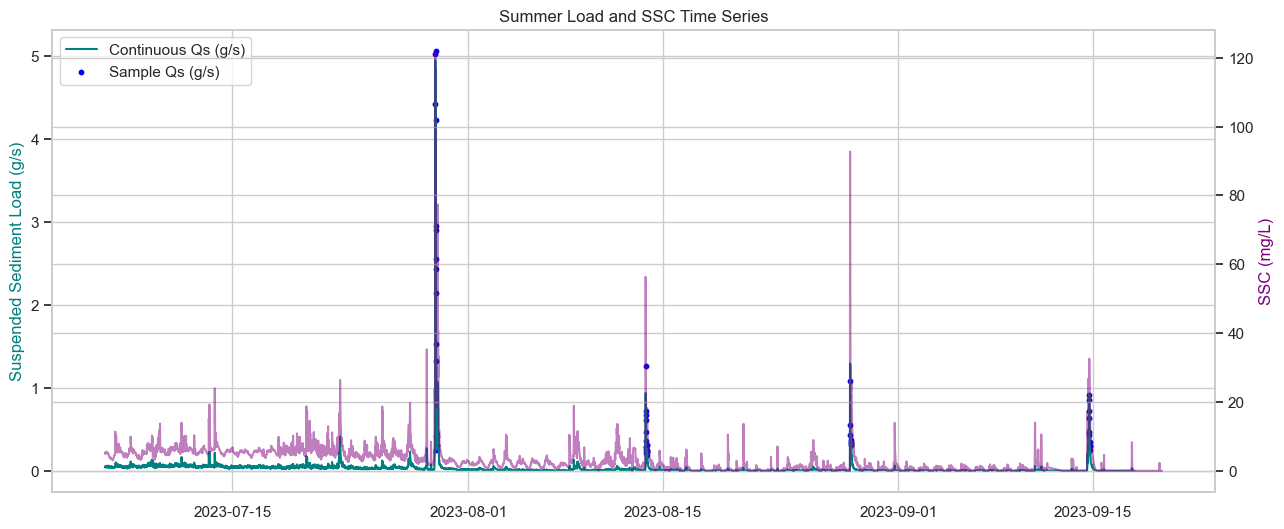

In [8]:
# plot time series of spring continuous record
plt.figure(figsize=(15, 6))
plt.plot(SSC_summer.index, SSC_summer['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(SSC_summer_sample.index, SSC_summer_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(SSC_summer.index, SSC_summer['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.5)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Summer Load and SSC Time Series')
plt.show()

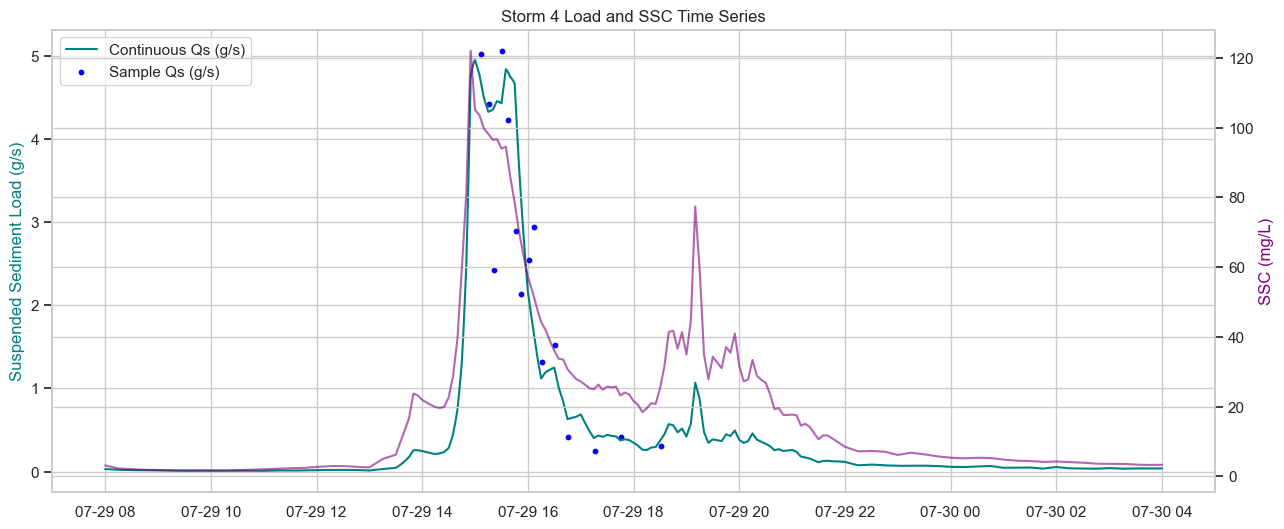

In [9]:
# Storm 4: 
# 07/29/23 to 08/01/23
storm_start = '2023-07-29 08:00:00'
storm_end = '2023-07-30 04:00:00'
# filter storm data
storm4 = SSC_summer.loc[storm_start:storm_end] 
storm4_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm4.index, storm4['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm4_sample.index, storm4_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm4.index, storm4['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 4 Load and SSC Time Series')
plt.show()


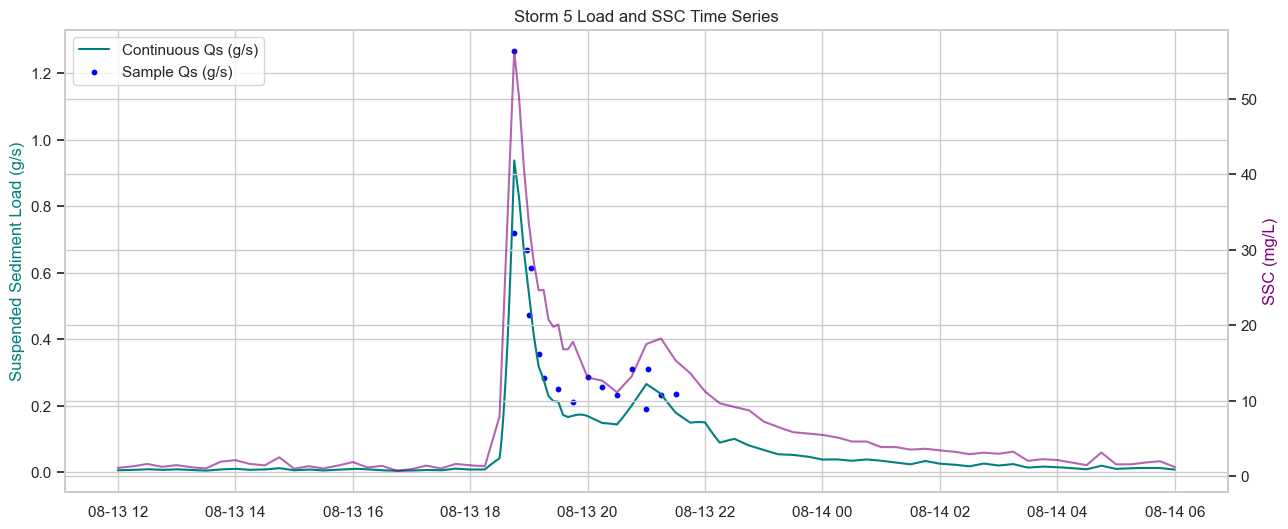

In [10]:
# Storm 5: 
# 08/13/23 to 08/14/23
storm_start = '2023-08-13 12:00:00'
storm_end = '2023-08-14 06:00:00'
# filter storm data
storm5 = SSC_summer.loc[storm_start:storm_end] 
storm5_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm5.index, storm5['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm5_sample.index, storm5_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm5.index, storm5['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 5 Load and SSC Time Series')
plt.show()

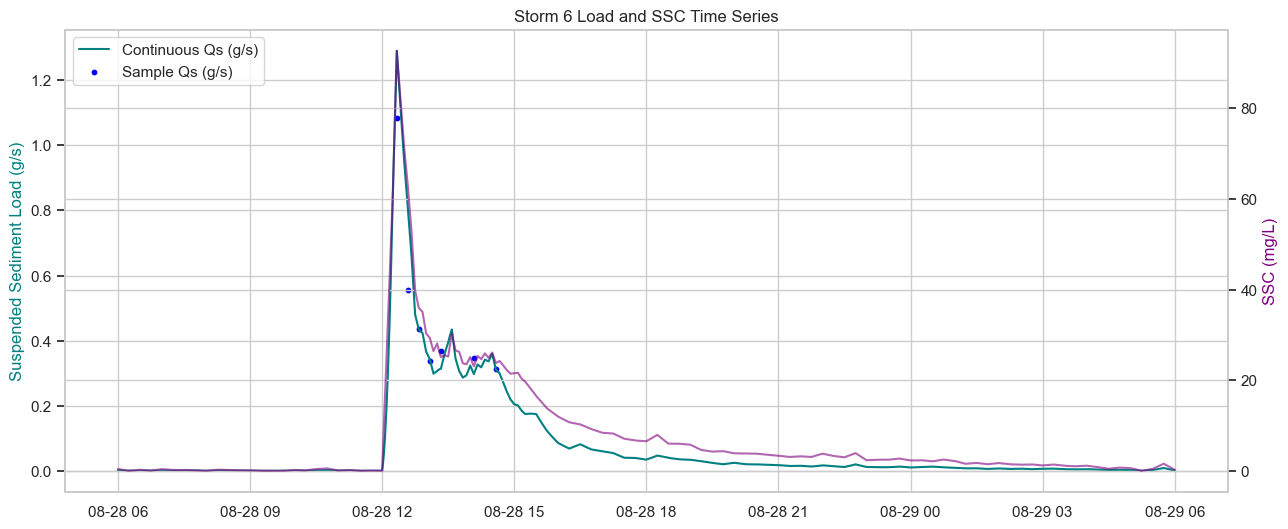

In [11]:
# Storm 6: 
# 08/28/23 to 08/29/23
storm_start = '2023-08-28 06:00:00'
storm_end = '2023-08-29 06:00:00'
# filter storm data
storm6 = SSC_summer.loc[storm_start:storm_end] 
storm6_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm6.index, storm6['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm6_sample.index, storm6_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm6.index, storm6['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 6 Load and SSC Time Series')
plt.show()

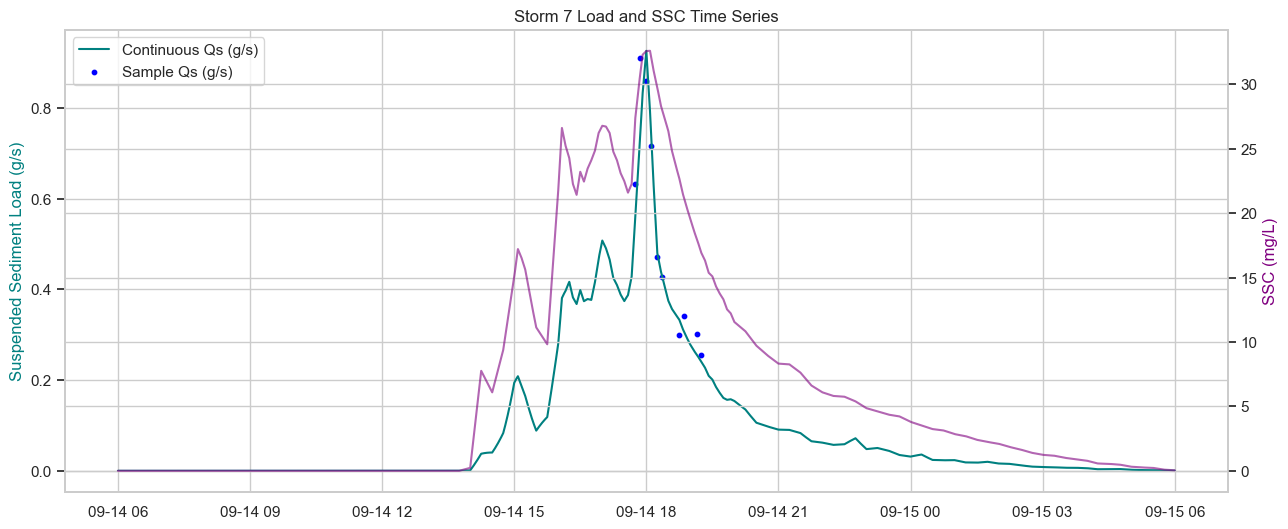

In [12]:
# Storm 7: 
# 09/14/23 to 09/15/23
storm_start = '2023-09-14 06:00:00'
storm_end = '2023-09-15 06:00:00'
# filter storm data
storm7 = SSC_summer.loc[storm_start:storm_end] 
storm7_sample = SSC_summer_sample.loc[storm_start:storm_end]
# plot storm 4 time series
plt.figure(figsize=(15, 6)) 
plt.plot(storm7.index, storm7['Qs'], label='Continuous Qs (g/s)', color='teal')
plt.scatter(storm7_sample.index, storm7_sample['Qs'], label='Sample Qs (g/s)', color='blue', s=10)
plt.ylabel('Suspended Sediment Load (g/s)', color='teal')
plt.legend(loc='upper left')
# in a different axis, plot SSC (mg/L)
ax2 = plt.gca().twinx()
ax2.plot(storm7.index, storm7['SSC (mg/L)'], label='SSC (mg/L)', color='purple', alpha=0.6)
plt.xlabel('Date')
ax2.set_ylabel('SSC (mg/L)', color='purple')
plt.title('Storm 7 Load and SSC Time Series')
plt.show()

### Export to csv

In [13]:
# delete all columns except for SSC, Q and Qs
SSC_spring_sample = SSC_spring_sample[['Sample ', 'SSC', 'Q', 'Qs']]
SSC_summer_sample = SSC_summer_sample[['Sample ', 'SSC', 'Q', 'Qs']]

# save the data
SSC_spring.to_csv('suspended_sediment_load/Qs_spring_continuous.csv')
SSC_summer.to_csv('suspended_sediment_load/Qs_summer_continuous.csv')
SSC_spring_sample.to_csv('suspended_sediment_load/Qs_spring_sample.csv')
SSC_summer_sample.to_csv('suspended_sediment_load/Qs_summer_sample.csv')

## Sediment Load by GSD

Load GSD data 

In [15]:
GSD_spring = pd.read_csv('suspended_sediment_load/Qs_spring_sample_GSD.csv', parse_dates=True, index_col='Date_Time')
GSD_summer = pd.read_csv('suspended_sediment_load/Qs_summer_sample_GSD.csv', parse_dates=True, index_col='Date_Time')

Spring

In [16]:
GSD_spring = GSD_spring.sort_index()
sample_times = GSD_spring.index.to_list() # convert index to list of sample times

# midpoints between samples
midpoints = [] # list to store midpoints

# first midpoint is before the first sample
midpoints.append(sample_times[0] - (sample_times[1] - sample_times[0]) / 2)
# midpoints between samples
for i in range(len(sample_times) - 1):
    midpoints.append(sample_times[i] + (sample_times[i + 1] - sample_times[i]) / 2)
# last midpoint is after the last sample
midpoints.append(sample_times[-1] + (sample_times[-1] - sample_times[-2]) / 2)
print(midpoints)

# assign interpolated GSD to continuous data
grain_cols = GSD_spring.columns[4:] # ignoring the first four columns which are not grain sizes
grain_cols
# add grain size columns to SSC_spring
for grain in grain_cols:
    SSC_spring[f'Qs_{grain}'] = np.nan # initialize with NaN values

[Timestamp('2023-04-17 14:30:00'), Timestamp('2023-04-17 18:30:00'), Timestamp('2023-04-17 22:30:00'), Timestamp('2023-04-18 02:30:00'), Timestamp('2023-04-18 10:30:00'), Timestamp('2023-04-18 16:30:00'), Timestamp('2023-04-18 19:00:00'), Timestamp('2023-04-18 21:30:00'), Timestamp('2023-04-19 00:00:00'), Timestamp('2023-04-19 02:30:00'), Timestamp('2023-04-19 05:00:00'), Timestamp('2023-04-19 10:00:00'), Timestamp('2023-04-19 17:30:00'), Timestamp('2023-04-20 01:00:00'), Timestamp('2023-04-20 13:30:00'), Timestamp('2023-04-21 04:30:00'), Timestamp('2023-04-21 14:30:00'), Timestamp('2023-04-22 00:30:00'), Timestamp('2023-04-22 10:30:00'), Timestamp('2023-04-22 18:00:00'), Timestamp('2023-04-23 11:15:00'), Timestamp('2023-04-24 09:30:00'), Timestamp('2023-04-24 19:30:00'), Timestamp('2023-04-26 19:00:00'), Timestamp('2023-04-29 14:30:00'), Timestamp('2023-04-30 15:30:00'), Timestamp('2023-04-30 18:00:00'), Timestamp('2023-04-30 20:30:00'), Timestamp('2023-05-01 06:30:00'), Timestamp('20

In [17]:
# loop through intervals between midpoints
for i in range(len(sample_times)):
    start = midpoints[i]
    end = midpoints[i + 1]

    # mask rows in SSC_spring between the start and end time
    gsd_times = (SSC_spring.index >= start) & (SSC_spring.index < end)
    # getting the grain size proportions for this sample (row i in GSD_spring)
    gsd_row = GSD_spring.iloc[i][grain_cols]  

    # multiply Qs at each timestamp in the mask by each grain size, and assign that to the new columns
    for grain in grain_cols:
        # for the masked time range, multiply total load by the grain's proportion
        SSC_spring.loc[gsd_times, f'Qs_{grain}'] = SSC_spring.loc[gsd_times, 'Qs'] * gsd_row[grain]

C:\Users\nicol\AppData\Local\Temp\ipykernel_13260\3736848013.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('copper', len(example_sizes))


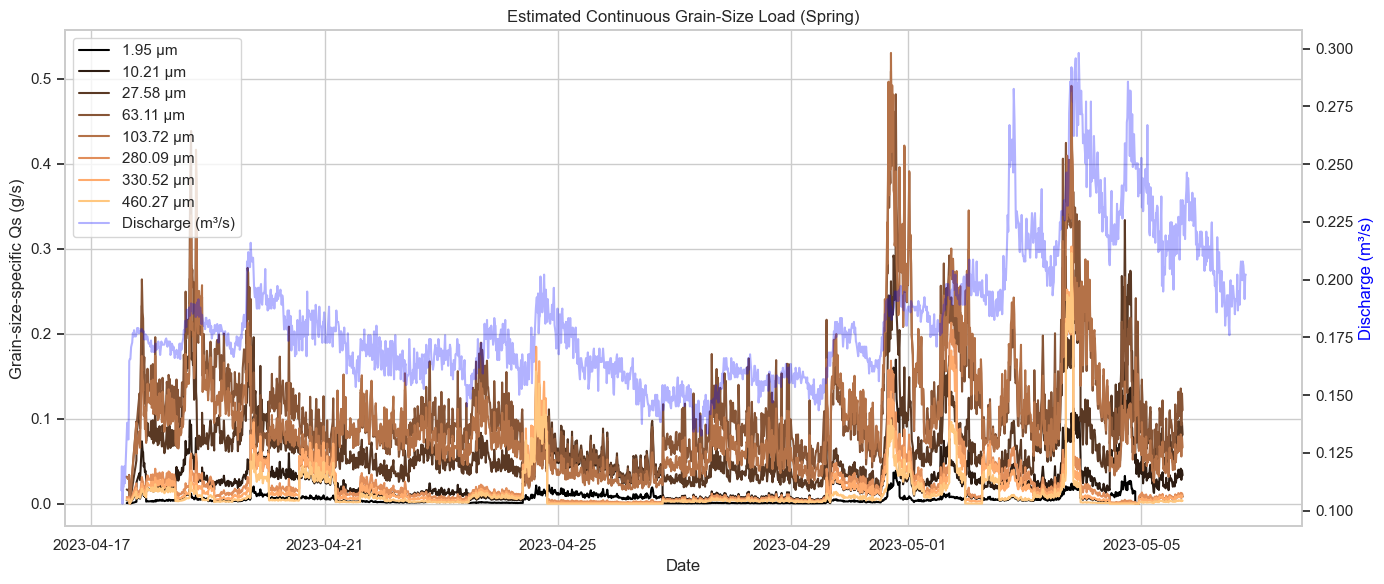

In [18]:
example_sizes = ['1.95', '10.21', '27.58', '63.11', '103.72', '280.09', '330.52', '460.27']

# normalize colormap over the number of sizes
cmap = cm.get_cmap('copper', len(example_sizes)) 
norm = mcolors.Normalize(vmin=0, vmax=len(example_sizes)-1)

fig, ax1 = plt.subplots(figsize=(14, 6))
# each grain size with a color from the colormap
for i, size in enumerate(example_sizes):
    col = f'Qs_{size}'
    if col in SSC_spring.columns:
        color = cmap(i)  # get color based on index
        ax1.plot(SSC_spring.index, SSC_spring[col], label=f'{size} µm', color=color)

# grain-size-specific Qs
ax1.set_ylabel('Grain-size-specific Qs (g/s)')
ax1.set_xlabel('Date')
ax1.set_title('Estimated Continuous Grain-Size Load (Spring)')

# discharge
ax2 = ax1.twinx()
ax2.plot(SSC_spring.index, SSC_spring['Q'], label='Discharge (m³/s)', color='blue', alpha=0.3)
ax2.set_ylabel('Discharge (m³/s)', color='blue')
ax2.grid(False) 

# combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()


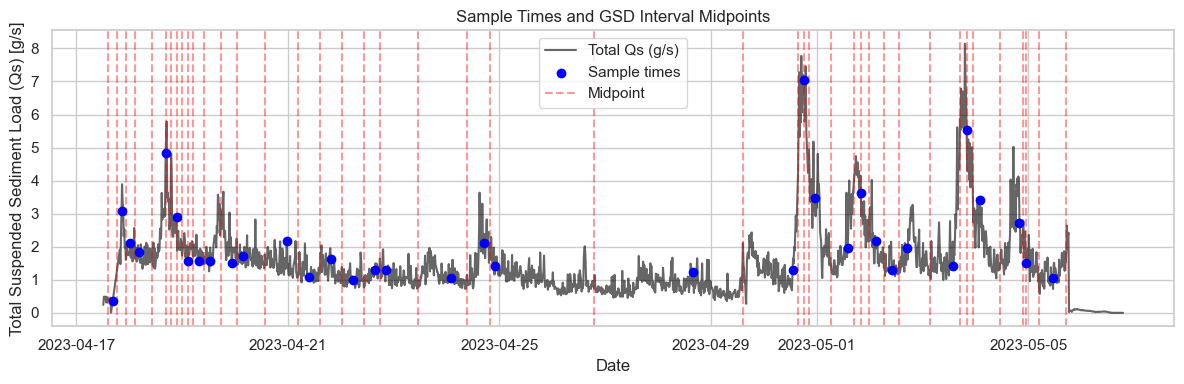

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(SSC_spring.index, SSC_spring['Qs'], label='Total Qs (g/s)', color='black', alpha=0.6)

sample_times = GSD_spring.index.to_list()
sample_times = pd.to_datetime(pd.Series(sample_times)).drop_duplicates().sort_values()

Qs_at_samples = SSC_spring['Qs'].reindex(SSC_spring.index.union(sample_times)).interpolate().loc[sample_times]
plt.scatter(np.array(sample_times), Qs_at_samples.to_numpy(), color='blue', label='Sample times', zorder=5)

# plot vertical lines at each midpoint
for midpoint in midpoints:
    plt.axvline(midpoint, color='red', linestyle='--', alpha=0.4, label='Midpoint')

# avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

plt.title('Sample Times and GSD Interval Midpoints')
plt.xlabel('Date')
plt.ylabel('Total Suspended Sediment Load (Qs) [g/s]')
plt.tight_layout()
plt.show()

Summer

In [20]:
GSD_summer = GSD_summer.sort_index()
sample_times = GSD_summer.index.to_list() # convert index to list of sample times

start_time = SSC_summer.index.min()
end_time = SSC_summer.index.max()

# midpoints between samples
midpoints = [] # list to store midpoints
# first midpoint is before the first sample
midpoints.append(start_time)
# midpoints between samples
for i in range(len(sample_times) - 1):
    midpoints.append(sample_times[i] + (sample_times[i + 1] - sample_times[i]) / 2)
# last midpoint is after the last sample
midpoints.append(end_time)

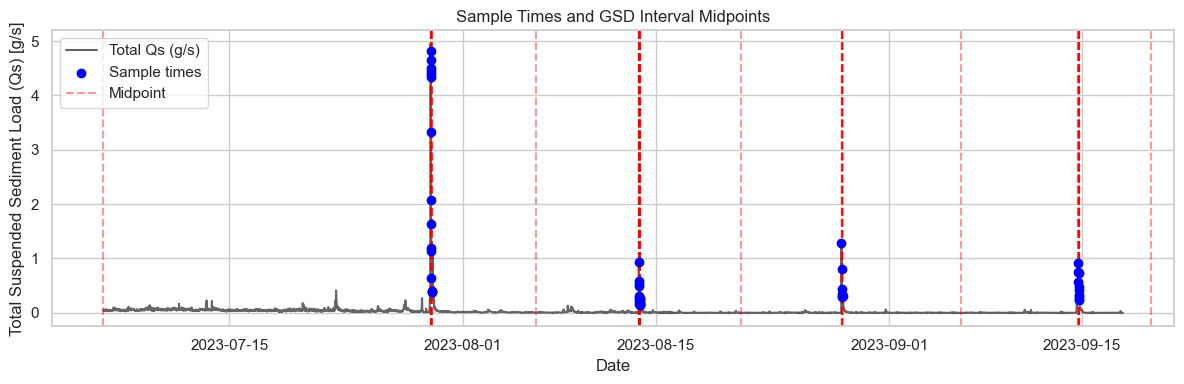

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(SSC_summer.index, SSC_summer['Qs'], label='Total Qs (g/s)', color='black', alpha=0.6)

sample_times = GSD_summer.index.to_list()
sample_times = pd.to_datetime(pd.Series(sample_times)).drop_duplicates().sort_values()

Qs_at_samples = SSC_summer['Qs'].reindex(SSC_summer.index.union(sample_times)).interpolate().loc[sample_times]
plt.scatter(np.array(sample_times), Qs_at_samples.to_numpy(), color='blue', label='Sample times', zorder=5)

# plot vertical lines at each midpoint
for midpoint in midpoints:
    plt.axvline(midpoint, color='red', linestyle='--', alpha=0.4, label='Midpoint')

# avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())

plt.title('Sample Times and GSD Interval Midpoints')
plt.xlabel('Date')
plt.ylabel('Total Suspended Sediment Load (Qs) [g/s]')
plt.tight_layout()
plt.show()

In [22]:
# assign interpolated GSD to continuous data
grain_cols = GSD_summer.columns[4:] # ignoring the first four columns which are not grain sizes
grain_cols
# add grain size columns to SSC_spring
for grain in grain_cols:
    SSC_summer[f'Qs_{grain}'] = np.nan # initialize with NaN values

# loop through intervals between midpoints
for i in range(len(sample_times)):
    start = midpoints[i]
    end = midpoints[i + 1]

    # mask rows in SSC_spring between the start and end time
    gsd_times = (SSC_summer.index >= start) & (SSC_summer.index < end)
    # getting the grain size proportions for this sample (row i in GSD_spring)
    gsd_row = GSD_summer.iloc[i][grain_cols]  

    # multiply Qs at each timestamp in the mask by each grain size, and assign that to the new columns
    for grain in grain_cols:
        # for the masked time range, multiply total load by the grain's proportion
        SSC_summer.loc[gsd_times, f'Qs_{grain}'] = SSC_summer.loc[gsd_times, 'Qs'] * gsd_row[grain]

C:\Users\nicol\AppData\Local\Temp\ipykernel_13260\4052962739.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('copper', len(example_sizes))


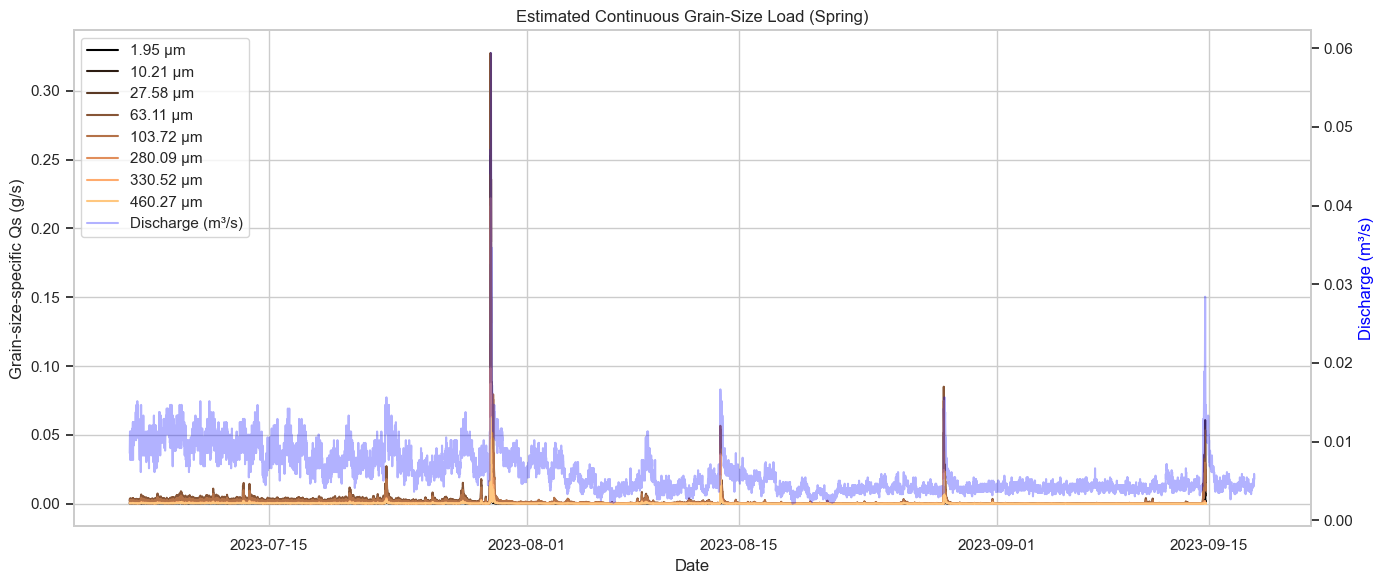

In [23]:
example_sizes = ['1.95', '10.21', '27.58', '63.11', '103.72', '280.09', '330.52', '460.27']

# normalize colormap over the number of sizes
cmap = cm.get_cmap('copper', len(example_sizes)) 
norm = mcolors.Normalize(vmin=0, vmax=len(example_sizes)-1)

fig, ax1 = plt.subplots(figsize=(14, 6))
# each grain size with a color from the colormap
for i, size in enumerate(example_sizes):
    col = f'Qs_{size}'
    if col in SSC_summer.columns:
        color = cmap(i)  # get color based on index
        ax1.plot(SSC_summer.index, SSC_summer[col], label=f'{size} µm', color=color)

# grain-size-specific Qs
ax1.set_ylabel('Grain-size-specific Qs (g/s)')
ax1.set_xlabel('Date')
ax1.set_title('Estimated Continuous Grain-Size Load (Spring)')

# discharge
ax2 = ax1.twinx()
ax2.plot(SSC_summer.index, SSC_summer['Q'], label='Discharge (m³/s)', color='blue', alpha=0.3)
ax2.set_ylabel('Discharge (m³/s)', color='blue')
ax2.grid(False) 

# combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

## Calculating total transported load

Spring Integration

In [45]:
# identify grain-size Qs columns
grain_cols_Qs = [col for col in SSC_spring.columns if col.startswith('Qs_')]
# compute time differences in seconds between samples
time_deltas = SSC_spring.index.to_series().diff().dt.total_seconds().fillna(0).values  # first value is 0
# empty dictionary to store total mass per grain size
total_mass_per_grain_spring = {}

# lopp through each grain-size column and integrate over time
for grain_col in grain_cols_Qs:
    # multiply Qs (g/s) × delta_t (s) to get grams at each step
    Qs_values = SSC_spring[grain_col].fillna(0).values  # replace NaNs with 0
    mass = (Qs_values * time_deltas).sum()  # result in grams
    total_mass_per_grain_spring[grain_col] = mass

Summer Integration

In [44]:
# identify grain-size Qs columns
grain_cols_Qs = [col for col in SSC_summer.columns if col.startswith('Qs_')]
# compute time differences in seconds between samples
time_deltas = SSC_summer.index.to_series().diff().dt.total_seconds().fillna(0).values  # first value is 0
# empty dictionary to store total mass per grain size
total_mass_per_grain_summer = {}

# lopp through each grain-size column and integrate over time
for grain_col in grain_cols_Qs:
    # multiply Qs (g/s) × delta_t (s) to get grams at each step
    Qs_values = SSC_summer[grain_col].fillna(0).values  # replace NaNs with 0
    mass = (Qs_values * time_deltas).sum()  # result in grams
    total_mass_per_grain_summer[grain_col] = mass

Plot

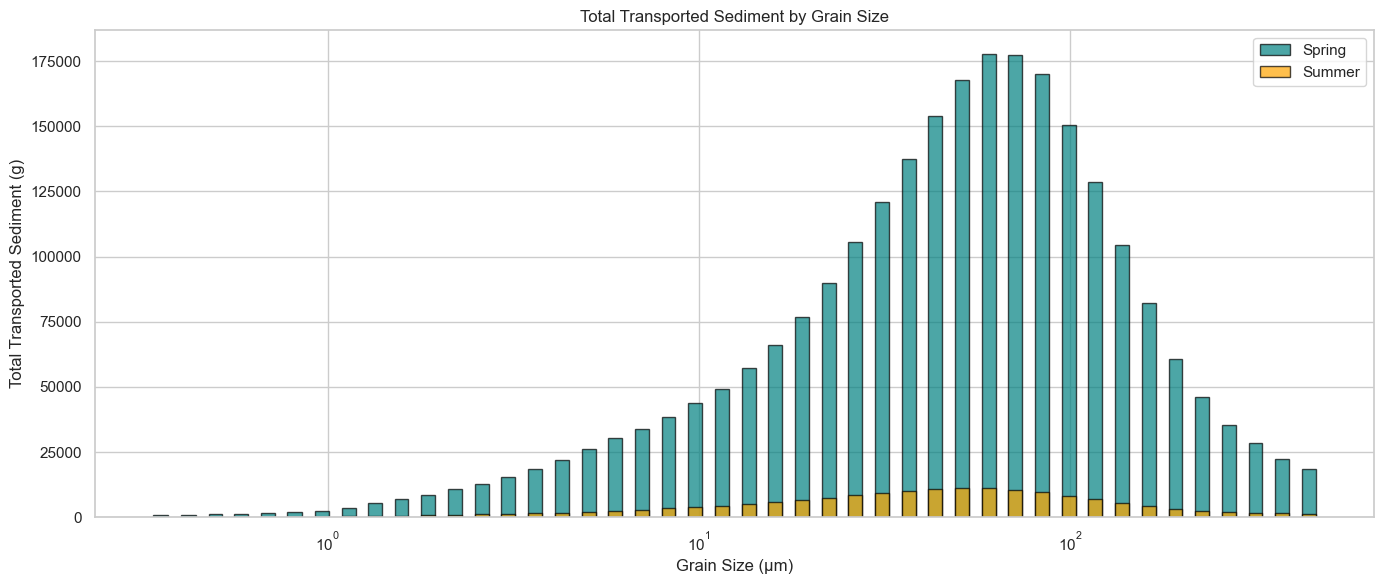

In [ ]:
# convert dictionary to DataFrame for plotting
spring_mass_df = pd.DataFrame.from_dict(total_mass_per_grain_spring, orient='index', columns=['Total_grams'])
summer_mass_df = pd.DataFrame.from_dict(total_mass_per_grain_summer, orient='index', columns=['Total_grams'])
# remove Qs_ prefix
spring_mass_df.index = spring_mass_df.index.str.replace('Qs_', '')  
summer_mass_df.index = summer_mass_df.index.str.replace('Qs_', '')
# convert index to float so sorting is by size, not text
spring_mass_df.index = spring_mass_df.index.astype(float)
summer_mass_df.index = summer_mass_df.index.astype(float)
# sort by grain size
spring_mass_df = spring_mass_df.sort_index()
summer_mass_df = summer_mass_df.sort_index()

# calculations for the plot: 
# get grain sizes and values
grain_sizes = np.array(sorted(spring_mass_df.index.union(summer_mass_df.index)))
spring_vals = spring_mass_df.reindex(grain_sizes, fill_value=0)['Total_grams'].values
summer_vals = summer_mass_df.reindex(grain_sizes, fill_value=0)['Total_grams'].values
# calculate log-spaced widths
log_sizes = np.log10(grain_sizes)
bin_edges = np.concatenate([
    [log_sizes[0] - (log_sizes[1] - log_sizes[0]) / 2],
    (log_sizes[1:] + log_sizes[:-1]) / 2,
    [log_sizes[-1] + (log_sizes[-1] - log_sizes[-2]) / 2]
])
bar_centers = log_sizes
bar_widths = np.diff(bin_edges)

# convert back to linear space for plotting
x_vals = 10**bar_centers
widths = 10**(bar_centers + bar_widths/2) - 10**(bar_centers - bar_widths/2)

# plot
plt.figure(figsize=(14, 6))
plt.bar(x_vals - widths/4, spring_vals, width=widths/2, color='teal', alpha=0.7, label='Spring', align='center', edgecolor='black')
plt.bar(x_vals - widths/4, summer_vals, width=widths/2, color='orange', alpha=0.7, label='Summer', align='center', edgecolor='black')

plt.xscale('log')
plt.xlabel('Grain Size (µm)')
plt.ylabel('Total Transported Sediment (g)')
plt.title('Total Transported Sediment by Grain Size')
plt.legend()
plt.tight_layout()
plt.show()


In [58]:
# export the total masses to CSV
spring_mass_df.to_csv('transported_mass/total_mass_spring.csv')
summer_mass_df.to_csv('transported_mass/total_mass_summer.csv')